# Model Evaluation / Comparison

In [1]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you prolly won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

In [2]:
import torch
from tools import plot_column_from_csv, load_model, torcherize_batch, get_data_loader, import_from_nested_path

In [9]:
models_to_compare = [
    'customGPT_1m_5ft11_and_skinnyfat',
    'customGPT_1m_short_and_thicc',
    'customGPT_1m_tall_and_skinny',
    'customGPT_2m_CosineNorm',
    'customGPT_2m_LayerNorm',
    'customGPT_2m_RMSNorm'
]

### first up we'll look at loss curves
notice that even with a log scale I had to splice out the first 10% to make the lines distinct

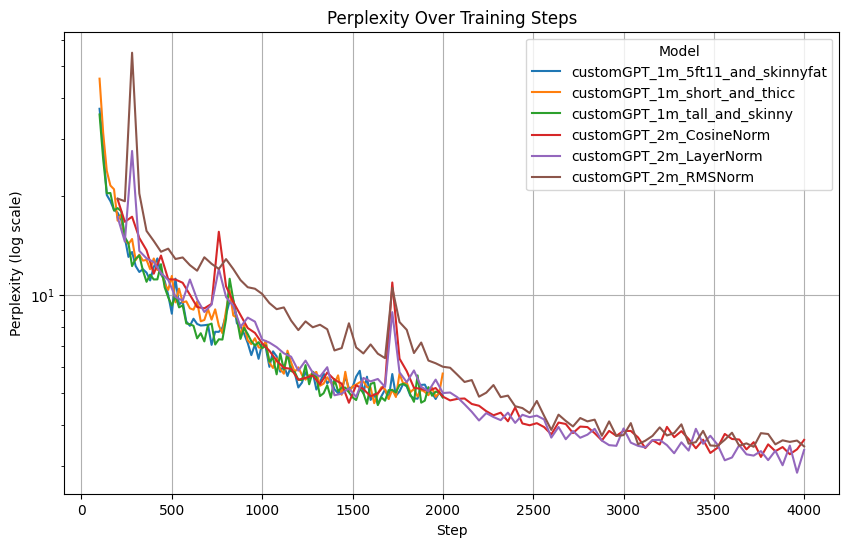

In [10]:
plot_column_from_csv(models_to_compare, 'Step', 'Perplexity', log_y=True, trim_percentage=5)

### now let's compare individual token accuracies
we'll compare topk teacher-forcing accuracies since these models really aren't good enough to be looking at actual inference output

In [11]:
# Data preparation
data_loader = get_data_loader(batch_size = 1, split = 'validation') # batch size can only be 1 until i fix batched inference
text = next(iter(data_loader))

In [12]:
def calculate_topk_accuracy(logits, targets, k=5, padding_idx=None):
    # Calculate top-k predictions
    topk_indices = torch.topk(logits, k, dim=2).indices
    
    # Create a mask for valid (non-padding) targets
    if padding_idx is not None:
        valid_targets = targets != padding_idx
    else:
        valid_targets = torch.ones_like(targets, dtype=torch.bool)
    
    # Calculate correctness only where the target is valid
    correct = topk_indices.eq(targets.unsqueeze(2).expand_as(topk_indices)) & valid_targets.unsqueeze(2)
    
    # Calculate accuracy only on valid targets
    valid_correct = correct.any(dim=2)[valid_targets]
    if valid_correct.numel() == 0:
        return torch.tensor(0.0)  # return 0 if there are no valid targets to avoid division by zero
    else:
        return valid_correct.float().mean()

In [13]:
# Evaluate models
results = {}
for model_name in models_to_compare:
    model, tokenizer, cfg = load_model(model_name)

    x, y = torcherize_batch(tokenizer, text, max_seq_len = cfg.max_seq_len)
    # x and y are tensors shape [batch_size, max_seq_len] of dtype torch.int64
    
    with torch.no_grad():
        logits, _ = model(x)

    topk = 5
    topk_accuracy = calculate_topk_accuracy(logits, y, k = topk, padding_idx = cfg.vocab_len - 1)
    topk_indices = torch.topk(logits, topk, dim=2).indices
    
    # Store results
    results[model_name] = {
        'accuracy': topk_accuracy.item(),
        'topk_indices': topk_indices,
        'tokenizer': tokenizer
    }

931.136K parameters
ModelConfig(dim=64, device='cpu', tokenizer='bpe', vocab_len=8192, num_layers=8, second_resid_norm=False, mlp_hidden_mult=4, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=4, num_kv_heads=1, head_dim=28, theta=10000, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1)
Model(
  (token_embedder): Embedding(8195, 64)
  (layers): ModuleList(
    (0-7): 8 x Layer(
      (pre_attn_norm): Norm()
      (attn): MQA(
        (Wq): Linear(in_features=64, out_features=112, bias=False)
        (Wk): Linear(in_features=64, out_features=28, bias=False)
        (Wv): Linear(in_features=64, out_features=28, bias=False)
        (Wo): Linear(in_features=112, out_features=64, bias=False)
      )
      (pre_mlp_norm): Norm()
      (mlp): MLP(
        (Wup): Linear(in_features=64, out_features=170, bias=False)
        (Wgate): Linear(in_features=64, out_features=170, bias=False)
        (Wdown)

In [14]:
# Define a function to format the model output
def format_model_output(model_name, data, topk, tokenizer):
    print(f"Model: {model_name}")
    print(f"  - Top-{topk} Accuracy: {data['accuracy']*100:.2f}%")
    
    # Extract the topk indices from the results
    topk_indices = data['topk_indices']
    
    # Assuming `y` is accessible here as the true targets or passed similarly to tokenizer
    batch_size, seq_len = topk_indices.shape[:2]
    
    # Display comparisons
    print('True\tPredicted')
    for j in range(25):
        true_token = tokenizer.expand_token(y[0, j].item())  # Get the true token
        predicted_tokens = [tokenizer.expand_token(idx) for idx in topk_indices[0, j]]  # List of predicted tokens
            
        # Display true and predicted tokens
        print(f"{true_token}\t{predicted_tokens}")
    print()

# Display the results for each model
for name, data in results.items():
    format_model_output(name, data, topk, data['tokenizer'])

Model: customGPT_1m_5ft11_and_skinnyfat
  - Top-5 Accuracy: 64.65%
True	Predicted
Tim	['Once', 'On', 'Lily', 'To', 'Ann']
 	['', ', ', "'s", ', "', 'zy']
and	['and', 'was', 'like', 'had', 'ar']
 	['', '', ' "', ', ', 'ra']
Liz	['To', 'Sam', 'Be', 'Lily', 'Mi']
 	['zy', '', 'ache', 'ie', '']
like	['were', 'like', 'ar', 'was', '']
d	['', '', 'resp', 'like', 'love']
 	['', '', ' 3', 'nel', 'Christ']
to	['to', 'walk', '', 'Sam', 'happily']
 	['', 'get', ', ', '.\n', 'as']
pla	['pla', 'go', 'walk', 'ru', 'hel']
y	['', '', 'nt', '. ', 'ye']
 	['', '. ', ', ', '.\n', 'ing']
in	['wi', 'in', 'out', 'and', 'on']
 	['', '. ', '.\n', ', ', 'cr']
th	['th', 'her', 'hi', '', 'it']
e	['', 'em', 'is', 'er', 'at']
 	['', 'ir', '. ', "'s", ' 3']
pa	['pa', 'ga', 'yard', 'sky', 'tr']
r	['', '', '. ', '', '']
k	['', 'ld', 'tle', 'ty', 'key']
. 	['. ', '', ', ', '.\n', '.\n"']
Th	['Th', 'On', '', 'He', 'Sh']
ey	['ey', '', 'en', 'is', 'er']

Model: customGPT_1m_short_and_thicc
  - Top-5 Accuracy: 64.84%
True	

# in the future it'd be cool to build out an automated GPT-4 rater like what they used in the TinyStories paper

# also once the hyperparameter search module is working i should build a system that performs a regression on the hyperparameters tested to predict teacher-forcing topk accuracy. likely need to include both linear, quadratic, & interaction terms in the regression and then do a lasso to remove useless terms